In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [71]:
# stamp, t1, t2, LLA_type, H_, prefix = '18399', 41, 45, 'дача', 300, 1
# stamp, t1, t2, LLA_type, H_, prefix = '69060', 62, 68, 'дача', 300, 2
# stamp, t1, t2, LLA_type, H_, prefix = '69060', 89.5, 95, 'дом', 1000, 3
# stamp, t1, t2, LLA_type, H_, prefix = '69060', 100, 107, 'дача', 300, 4
# stamp, t1, t2, LLA_type, H_, prefix = '69060', 151.5, 154.5, 'дача', 300, 5
# stamp, t1, t2, LLA_type, H_, prefix = '69060', 156.5, 200, 'дача', 300, 6
# stamp, t1, t2, LLA_type, H_, prefix = '88784', 54, 600, 'дача', 300, 7
# stamp, t1, t2, LLA_type, H_, prefix = '88784', 54, 600, 'дача', 300, 8

# stamp, t1, t2, LLA_type, H_, prefix = '99677', 20, 25, 'шер', 500, 'E'
# stamp, t1, t2, LLA_type, H_, prefix = '48506', 0, 200, 'кузьм', 1000, 'P1'

stamp, t1, t2, LLA_type, H_, prefix = '48506', 0, 200, 'кузьм', 1000, 'P1'

folder = 'graphics\\'

alm = pd.read_csv(f'almanac_solves{stamp}.csv')
eph = pd.read_csv(f'ephemeris_solves{stamp}.csv')
general = pd.read_csv(f'general_data_{stamp}.csv')
LLA = pd.read_csv(f'LFK_coordinates_lla{stamp}.csv')
XYZ = pd.read_csv(f'LFK_coordinates_xyz{stamp}.csv')
FFK = pd.read_csv(f'FFK_filtered{stamp}.csv')

In [72]:
alm['TOW'] = alm.calc_stamp.apply(lambda st: int(st[:-1].split('.')[1]))
eph['TOW'] = eph.calc_stamp.apply(lambda st: int(st[:-1].split('.')[1]))
general['TOW'] = general.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[1]))
general[['X', 'Y', 'Z']] = general[['ecefX', 'ecefY', 'ecefZ']] 
LLA['TOW'] = LLA.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[1]))
XYZ['TOW'] = XYZ.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[1]))
FFK['TOW'] = FFK.receiving_stamp.apply(lambda st: int(st[:-1].split('.')[1]))

alm['time'] = alm['TOW'] / 3600
eph['time'] = eph['TOW'] / 3600
general['time'] = general['TOW'] / 3600
LLA['time'] = LLA['TOW'] / 3600
XYZ['time'] = XYZ['TOW'] / 3600
FFK['time'] = FFK['TOW'] / 3600

def cut(table, t1, t2):
    return table[(t1 < table.time) & (table.time < t2)]

alm = cut(alm, t1, t2)
eph = cut(eph, t1, t2)
general = cut(general, t1, t2)
LLA = cut(LLA, t1, t2)
XYZ = cut(XYZ, t1, t2)
FFK = cut(FFK, t1, t2)

# alm = alm.head(1e4)
# eph = eph.head(1e4)
# general = general.head(1e4)
# LLA = LLA.head(1e4)
# XYZ = XYZ.head(1e4)

In [79]:
print(len(XYZ))
for table in [LLA, XYZ]:
    for i in range(3):
        name = ['normP_rec', 'normP_alm', 'normP_eph'][i]
        arr = list(LLA[name])[100:]
        print(f'{['rec', 'alm', 'eph'][i]}: {max(arr):.20f}, {min(arr):.20f}, {max(arr)-min(arr):.20f}')

9921
rec: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
alm: nan, nan, nan
eph: nan, nan, nan
rec: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
alm: nan, nan, nan
eph: nan, nan, nan


In [32]:
import pymap3d as pm
match LLA_type.lower():
    case 'дом':
        mylla = [55.690555555555555, 37.858333333333334, 140] # Дом
    case 'дача': 
        mylla = [55.569861111111116, 38.805027777777774, 140] # Дача
    case 'бамонка':
        mylla = [55.765854, 37.685520, 140] # бамонка
    case 'шер':
        mylla = [55.9735, 37.42105, 5000]
    case 'кузьм':
        mylla = [55.688824, 37.797327, 133]
ECEF = pm.geodetic2ecef(*mylla)
if H_ is None:
    H_ = 70000
MS = 3
normP_dead = 0.001070452    

In [33]:
def draw_filtered(DF, H, name, base):
    # DF = DF[(DF.normP_rec > normP_dead) & (DF.normP_alm > normP_dead) & (DF.normP_eph > normP_dead)]
    
    fig, axs = plt.subplots(3, figsize=(14, 8))
    type_names = 'XYZ' if name == 'XYZ' else ['lat', 'lon', 'alt']
    meas_type = [', km', ', km', ', km'] if name == 'XYZ' else [', deg', ', deg', ', m']
    scale = 1e-3 if name == 'XYZ' else 1
    for i, type in enumerate(type_names):
        for source in ['eph', 'alm', 'rec']:
            # print(f'{type}_{source}')
            # axs[i].plot(DF.time, DF[f'{type}_{source}'] * scale, label=source)
            axs[i].scatter(DF.time, DF[f'{type}_{source}'] * scale, label=source, s=MS)
        # if len(DF):
        axs[i].plot([min(eph.time), max(eph.time)], [base[i] * scale, base[i] * scale], '--', label='real', color='red')
        axs[i].set_ylabel(type + meas_type[i])
        axs[i].set_ylim((base[i] - H[i]) * scale, (base[i] + H[i]) * scale)
        axs[i].legend(loc='upper right')
        axs[i].grid()
    axs[0].set_title(f'Отфильтрованные коодинаты ({name}, ±{H_} m)')
    axs[-1].set_xlabel('TOW, h')
    plt.savefig(f'{folder}{prefix}_{name}_filtered{H_}.png', dpi=600)
    # plt.show()       
      

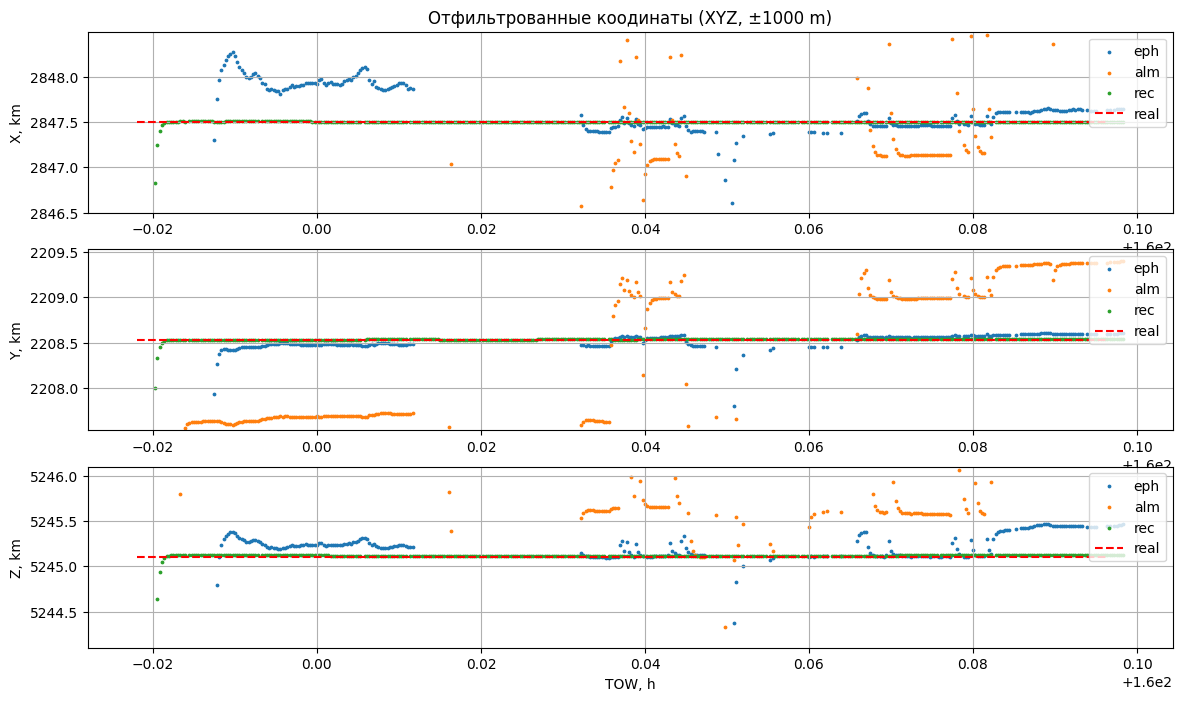

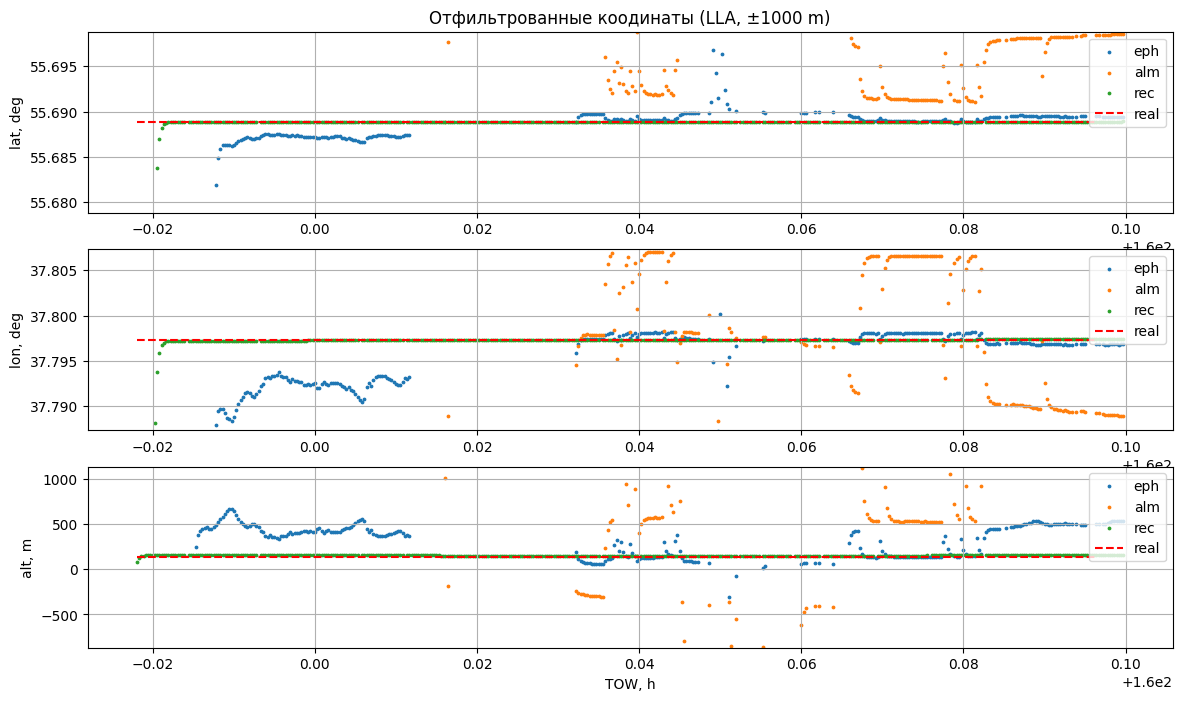

In [34]:









draw_filtered(XYZ, [H_, H_, H_], 'XYZ', ECEF)
draw_filtered(LLA, [H_ / 100e3, H_ / 100e3, H_ / 1], 'LLA', mylla)

In [35]:
# fig, axs = plt.subplots(3, figsize=(14, 8))
# for i, type in enumerate('XYZ'):
#     for name, DF in zip(['eph', 'alm', 'rec'], [eph, alm, general]):
#         if not len(DF):
#             continue
#         axs[i].scatter(DF.time, DF[type], label=name, s=MS)
#         # axs[i].plot(DF.time, DF[type], label=name)
#     axs[i].plot([min(eph.time), max(eph.time)], [ECEF[i], ECEF[i]], '--', label='real', color='red')
#     axs[i].set_ylabel(type + ', m')
#     axs[i].set_ylim(ECEF[i] - H_, ECEF[i] + H_)
#     axs[i].legend(loc='upper right')
#     axs[i].grid()
# axs[0].set_title(f'Рассчитанные координаты (±{H_} m)')
# axs[-1].set_xlabel('TOW, h')
# plt.savefig(f'calculated_xyz{H_}.png', dpi=600)
# # plt.show()

In [36]:
# fig, axs = plt.subplots(3, figsize=(14, 8))
# import Transformations
# for df in [general, eph, alm]:
#     df['lla'] = df.apply(lambda row: Transformations.ecef2lla(row.X, row.Y, row.Z), axis=1)
#     df['lat'] = df.lla.apply(lambda lla: lla[0])
#     df['lon'] = df.lla.apply(lambda lla: lla[1])
#     df['alt'] = df.lla.apply(lambda lla: lla[2])
# H = [H_ / 100e3, H_ / 100e3, H_ / 3]
# for i, type in enumerate(['lat', 'lon', 'alt']):
#     for name, DF in zip(['eph', 'alm', 'rec'], [eph, alm, general]):
#         axs[i].scatter(DF.time, DF[type], label=name, s=MS)
#         # axs[i].plot(DF.time, DF[type], label=name)
#     axs[i].plot([min(eph.time), max(eph.time)], [mylla[i], mylla[i]], '--', label='real', color='red')
#     axs[i].set_ylabel(type + ', m')
#     axs[i].set_ylim(mylla[i] - H[i], mylla[i] + H[i])
#     axs[i].legend(loc='upper right')
#     axs[i].grid()
# axs[0].set_title(f'Рассчитанные координаты (±{H_} m)')
# axs[-1].set_xlabel('TOW, h')
# plt.savefig(f'calculated_lla{H_}.png', dpi=600)


In [37]:
#TODO: график- количество спутников (АЕ), ошибка (RAE), ???
# H_ = 2000

In [38]:
# fig, axs = plt.subplots(3, figsize=(14, 8))
# for name, DF in zip(['eph', 'alm', 'rec'], [eph, alm, general ]):
#     DF['error'] = DF.apply(lambda row: np.linalg.norm([row.X-ECEF[0], row.Y-ECEF[1], row.Z-ECEF[2]]) , axis=1)
#     DF = DF[DF.error < H_]
#     axs[0].scatter(DF.time, DF['error'], label=name, s=MS)
#     if name != 'rec':
#         axs[1].scatter(DF.time, DF['sat_count'], label=name, s=MS)
#         axs[2].scatter(DF.time, DF['fval'], label=name, s=MS)
#     # axs[i].plot(DF.time, DF[type], label=name)
# axs[0].set_ylabel('error, m')
# axs[1].set_ylabel('sat count')
# axs[2].set_ylabel('fval, m')
# for i in range(3):
#     axs[i].legend(loc='upper right')
#     axs[i].grid()
# axs[0].set_title(f'Ошибка рассчитанных координат(±{H_} m)')
# axs[-1].set_xlabel('TOW, h')
# plt.savefig(f'error_and_satcount.png', dpi=600)

In [39]:
# fig, axs = plt.subplots(4, figsize=(14, 8))
# 
# for name, DF in zip(['eph', 'alm'], [ eph, alm]):
#     DF['error'] = DF.apply(lambda row: np.linalg.norm([row.X-ECEF[0], row.Y-ECEF[1], row.Z-ECEF[2]]) , axis=1)
#     for i, sat_count in enumerate([4, 5, 6, 7]):
#         DF1 = DF[(DF.error < H_) & (DF.sat_count == sat_count)]
#         axs[i].scatter(DF1.time, DF1['error'], label=name, s=MS)
#         axs[i].set_ylabel(f'{sat_count} sats error, m')
#         # if name != 'rec':
#         #     axs[1].scatter(DF.time, DF['sat_count'], label=name, s=MS)
#         # axs[i].plot(DF.time, DF[type], label=name)
# for i in range(4):
#     axs[i].legend(loc='upper right')
#     axs[i].grid()
# axs[0].set_title(f'Ошибка по количеству спутников (±{H_} m)')
# axs[-1].set_xlabel('TOW, h')
# plt.savefig(f'errorFORsatcount.png', dpi=600)

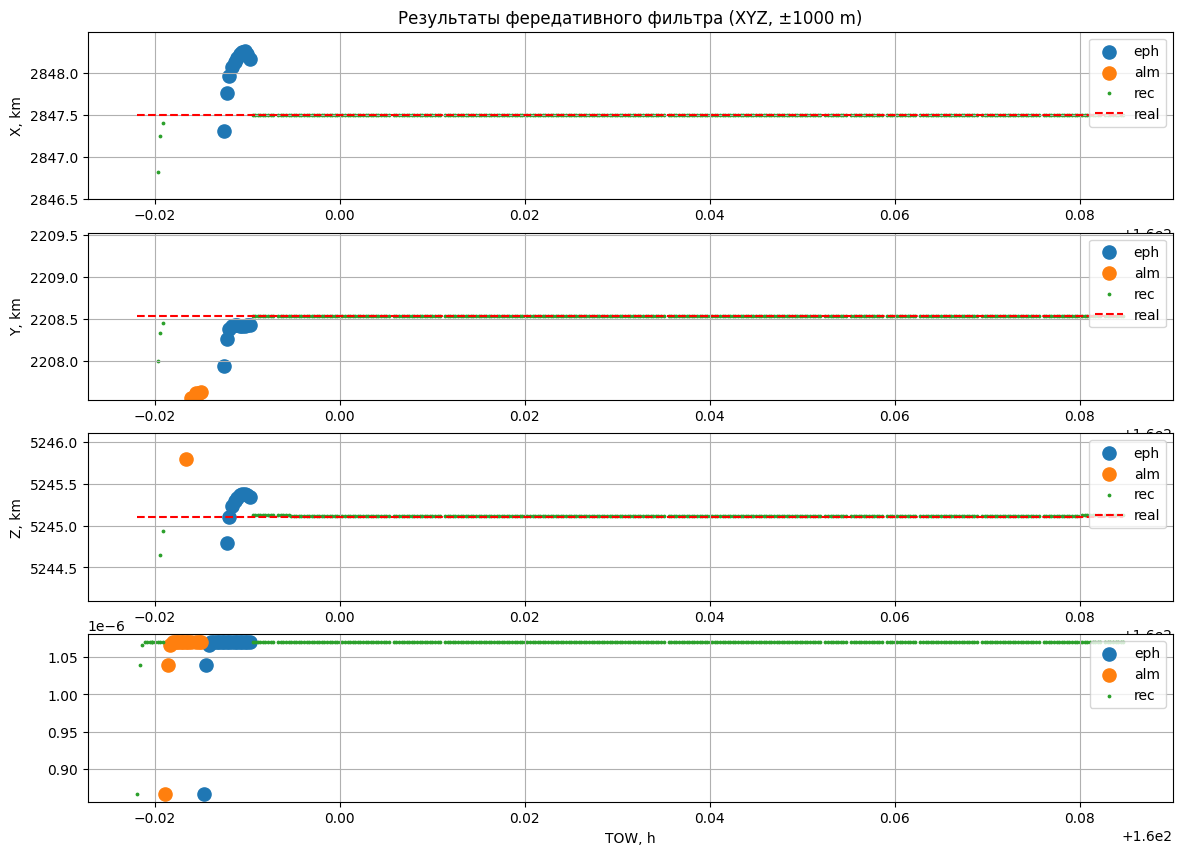

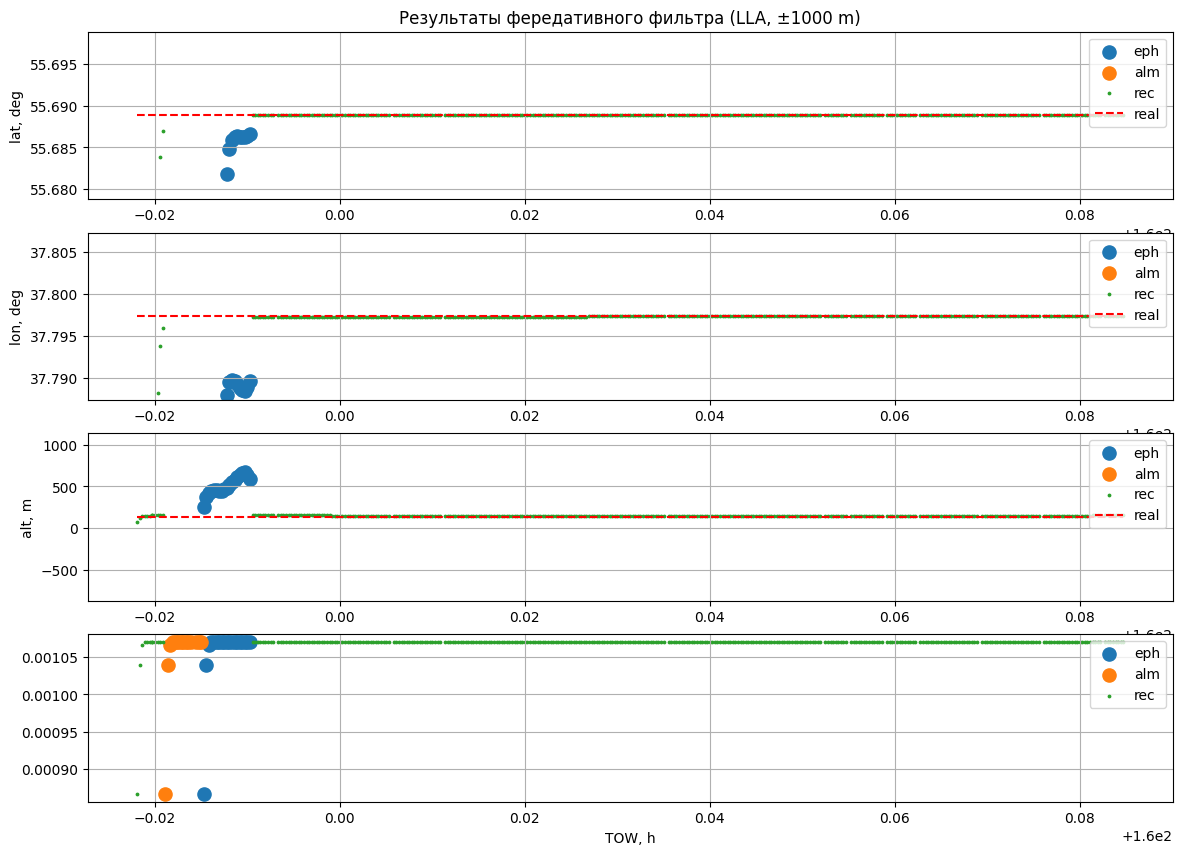

In [40]:
def draw_filtered_FFK(DF, H, name, base):
    fig, axs = plt.subplots(4, figsize=(14, 10))
    type_names = 'XYZ' if name == 'XYZ' else ['lat', 'lon', 'alt']
    type_source = 'xyz_source' if name == 'XYZ' else 'lla_source'
    type_val = 'xyz_val' if name == 'XYZ' else 'lla_val'
    meas_type = [', km', ', km', ', km'] if name == 'XYZ' else [', deg', ', deg', ', m']
    scale = 1e-3 if name == 'XYZ' else 1
    for i, type in enumerate(type_names):
        for source in ['eph', 'alm', 'rec']:
            D1 = DF[DF[type_source] == source]
            axs[i].scatter(D1.time, D1[type] * scale, label=source, s=MS if source == 'rec' else MS*30)
        axs[i].plot([min(DF.time), max(DF.time)], [base[i] * scale, base[i] * scale], '--', label='real', color='red')
        axs[i].set_ylabel(type + meas_type[i])
        axs[i].set_ylim((base[i] - H[i]) * scale, (base[i] + H[i]) * scale)
        axs[i].legend(loc='upper right')
        axs[i].grid()
    for source in ['eph', 'alm', 'rec']:
        D1 = DF[DF[type_source] == source]
        axs[3].scatter(D1.time, D1[type_val] * scale, label=source, s=MS if source == 'rec' else MS*30)
        axs[3].legend(loc='upper right')
        # axs[3].set_ylim([0.00107, 0.001071])
        axs[3].grid()
    axs[0].set_title(f'Результаты фередативного фильтра ({name}, ±{H_} m)')
    axs[-1].set_xlabel('TOW, h')
    plt.savefig(f'{folder}{prefix}_{name}_FFK{H_}.png', dpi=600)
    # plt.show()       

# H_ = 100e3
draw_filtered_FFK(FFK, [H_, H_, H_], 'XYZ', ECEF)
draw_filtered_FFK(FFK, [H_ / 100e3, H_ / 100e3, H_ / 1], 'LLA', mylla)

In [41]:
A1=0

In [47]:
# for i in range(50, len(LLA)):
line = LLA.loc[100]
r, a, e = line[['normP_rec', 'normP_alm', 'normP_eph']]
for x in [r, a, r]:
    print(f'{x:.20f}')
    

0.00107046626931919992
0.00107046626931919992
0.00107046626931919992


In [45]:
line = XYZ.loc[100]
r, a, e = line[['normP_rec', 'normP_alm', 'normP_eph']]
for x in [r, a, r]:
    print(f'{x:.20f}')
    

0.00107046626931919992
0.00107046626931919992
0.00107046626931919992


In [66]:
print(len(XYZ))
for table in [LLA, XYZ]:
    for i in range(3):
        name = ['normP_rec', 'normP_alm', 'normP_eph'][i]
        arr = list(LLA[name])[50:]
        print(f'{['rec', 'alm', 'eph'][i]}: {max(arr):.20f}, {min(arr):.20f}, {max(arr)-min(arr):.20f}')

434
rec: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
alm: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
eph: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
rec: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
alm: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000
eph: 0.00107046626931919992, 0.00107046626931919992, 0.00000000000000000000


array([[0.00086603,        nan,        nan],
       [0.00103923,        nan,        nan],
       [0.00106588,        nan,        nan],
       ...,
       [0.00107047, 0.00107047, 0.00107047],
       [0.00107047, 0.00107047, 0.00107047],
       [0.00107047, 0.00107047, 0.00107047]])